In [1]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
from lib_dojo.pipeline import PipelineProfiler
from lib_dojo.utils import scatterplot_score_emissions, load_cleaned_carlab_data

In [3]:
df = load_cleaned_carlab_data(data_path="../data")

**Description officielle des colonnes**

nom-colonne typerubrique  longueur  \
0      lib_mrq_utac      varchar        12   
1           hybride      varchar         3   
2    puiss_admin_98        varnb         2   
3         puiss_max        varnb        11   
4       conso_mixte        varnb        11   
5               co2        varnb         3   
6          co_typ_1        varnb        11   
7             hcnox        varnb        11   
8              ptcl        varnb         5   
9   masse_ordma_min        varnb         4   
10            gamme      varchar        14   

                                              légende              unité  
0                                           la marque                NaN  
1   une information permettant d’identifier les vé...                NaN  
2                         la puissance administrative                NaN  
3                       la puissance maximale (en kW)                 kW  
4   consommation extra urbaine de carburant (en l/...  litre pour 100 km  
5                        l'émission de CO2 (en g/km),      gramme par km  
6                    le résultat d’essai de CO type I      gramme par km  
7                        les résultats d’essai HC+NOX      gramme par km  
8                  le résultat d’essai de particules       gramme par km  
9                    la masse en ordre de marche mini                 kg  
10                                              gamme                NaN

**DataFrame head:**

hybride  puiss_admin_98  puiss_max  conso_mixte    co2  co_typ_1  hcnox  \
0     non              12      147.0          7.8  182.0     0.647    NaN   
1     non              12      147.0          8.0  186.0     0.647    NaN   
2     non               7      100.0          5.1  134.0     0.066  0.175   
3     non               7      100.0          5.1  134.0     0.066  0.175   
4     non               9      125.0          5.3  139.0     0.060  0.193   

    ptcl  masse_ordma_min      gamme typ_boite  nb_rapp  
0  0.002             1505  MOY-SUPER         M        6  
1  0.002             1555  MOY-SUPER         M        6  
2  0.001             1565  MOY-SUPER         M        6  
3  0.001             1565  MOY-SUPER         M        6  
4  0.001             1565  MOY-SUPER         M        6

**DataFrame shape: (55044, 12)**

In [4]:
class DatasetColumns:
    hybride = "hybride"
    ptcl = "ptcl"
    typ_boite = "typ_boite"
    puiss_admin_98 = "puiss_admin_98"
    puiss_max = "puiss_max"
    nb_rapp = "nb_rapp"
    conso_mixte = "conso_mixte"
    co2 = "co2"
    co_typ_1 = "co_typ_1"
    hcnox = "hcnox"
    masse_ordma_min = "masse_ordma_min"

    categorical_features = [hybride, ptcl, typ_boite]

    numerical_features = [
        puiss_admin_98, puiss_max, nb_rapp, conso_mixte, co2, co_typ_1, hcnox, ptcl, masse_ordma_min,
    ]

    columns_to_impute = [conso_mixte, co2, co_typ_1, hcnox, ptcl]


In [5]:
preprocessor = ColumnTransformer(
    [
        (
            "One hot encoding",
            OneHotEncoder(
                handle_unknown="ignore", drop="if_binary", sparse_output=False
            ),
            DatasetColumns.categorical_features,
        ),
        ("minmax", MinMaxScaler(), DatasetColumns.numerical_features),
    ],
    remainder="passthrough",
)

imputer = IterativeImputer(max_iter=10, random_state=0)

model = RandomForestClassifier(n_estimators=100, random_state=0)

In [6]:
pipeline = PipelineProfiler(
    data=df,
    imputer=imputer,
    preprocessor=preprocessor,
    cols_to_impute=DatasetColumns.columns_to_impute,
    target="gamme",
    sampling_strategy=None,
    feature_selection=None,
    model=model,
    search_method="none",
)

In [7]:
res1 = pipeline.fit()
print(res1)

Splitting data...
Imputing data...
Preprocessing data...
No oversampling performed
Data preprocessed.
Fitting model...
Model fitted.
{'model': RandomForestClassifier(random_state=0), 'impute_emissions': 4.9001403244375134e-05, 'preprocessing_emissions': 5.8967123681842186e-05, 'fitting_emissions': 0.0075396494500805265}


In [8]:
score = pipeline.score()
print(score)

Predicting...
here is X shape :  (11009, 11)
Prediction done.
0.8798072754077698


In [9]:
inf_res1 = {'total' : pipeline.inference_total_emissions, 'preprocessor' : pipeline.inference_preprocessing_emissions, 'imputer' : pipeline.inference_impute_emissions, 'model' : pipeline.inference_emissions}

In [10]:
pipeline.set_model(LogisticRegression())
res2 = pipeline.fit()

score2 = pipeline.score()

Data already splitted.
Data already imputed.
Data already preprocessed.
Fitting model...
Model fitted.
Predicting...
here is X shape :  (11009, 11)
Prediction done.


In [11]:
inf_res2 = {'total' : pipeline.inference_total_emissions, 'preprocessor' : pipeline.inference_preprocessing_emissions, 'imputer' : pipeline.inference_impute_emissions, 'model' : pipeline.inference_emissions}

In [12]:
model_comparison = {'RF' : {'score' : score, 'inference' : inf_res1['model'], 'train' : res1['fitting_emissions']}, 'LR' : {'score' : score2, 'inference' : inf_res2['model'], 'train' : res2['fitting_emissions']}}

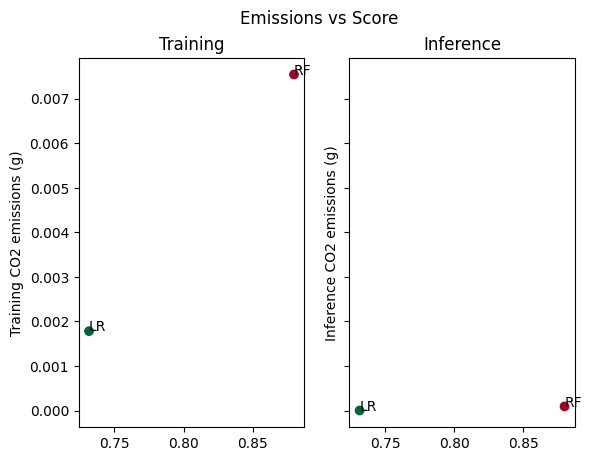

In [13]:
scatterplot_score_emissions(model_comparison)

In [14]:
print(model_comparison)

{'RF': {'score': 0.8798072754077698, 'inference': 9.500833021678676e-05, 'train': 0.0075396494500805265}, 'LR': {'score': 0.7316474675442376, 'inference': 4.11617226739294e-06, 'train': 0.0017832687779008364}}
